# Aplicando Machine Learning na análise de séries temporais para prever as vendas da loja equatoriana "Favorita"

## Uma visão geral sobre o problema e as técnicas utilizadas

Nesta análise são utilizadas técnicas de Machine Learning na análise de séries temporais de vendas de produtos da rede de lojas equatoriana "Favorita".

Os dados foram obtidos do Kaggle (https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data) e fornecem informações sobre as vendas de 33 famílias de produtos em 54 lojas da rede. Na tabela principal tem-se a quantidade de itens de cada família vendida por dia em cada loja e também a quantidade de itens em promoção. Outras variáves externas, que potencialmente influenciam as vendas, são sugeridas. São elas:

- **Valor do petróleo.** A economia do Equador é bastante dependente do petróleo e, portanto, o seu valor pode influenciar o comportamento de compras da população.
- **Feriados.**
- **Dias de pagamento dos funcionários públicos.** No Equador, os funcionários públicos são pagos quinzenalmente, no dia 15 e no último dia do mês. 

Nessa primeira análise, apenas uma loja e uma família de produtos foram sorteados para as análises. Para aplicar técnicas de Machine Learning na previsão de vendas da série temporal a função de autocorrelação parcial foi utilizada. A função de autocorrelação parcial é derivada da função de autocorrelação e mede a correlação das vendas com os dias anteriores mas penalizando padrões que se repetem. Por exemplo, se algum valor tem forte correlação com o valor da semana anterior, como é o caso das vendas que será análisado, a função de autocorrelação terá um comportamento períodico com picos a cada semana de atraso na função. A função de autocorrelação parcial atenua esses picos conforme eles se repetem.

Uma vez calculadas as autocorrelações parciais, os atrasos ("lags") que geram os sinais de maior intensidade são utilizados como "features" na modelagem. O problema de análise de uma série temporal é, dessa forma, transformado em um problema tradicional de Machine Learning, no qual as correlações temporais dos dados são transformadas em features, que são os valores das vendas nos devidos "lags" principais. 

Uma das principais vantagens dessa técnica é que váriaveis podem ser incluídas na análise de uma série temporal de forma relativamente simples. Outra vantagem importante é a possibilidade de se utilizar os diversos algorítmos de Machine Learning existentes.  

Aqui, o algorítmo XGBoost será utilizado no problema de regressão para se prever as vendas em uma janela de 15 dias. Conforme será visto, as melhores previsões são obtidas quando as "features" mencionadas acima são utilizadas excluindo-se os dias de pagamento.

## Análises preliminares

In [2]:
# importando as bibliotecas básicas principais
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# importando os dados e utilizando as datas como índice
df = pd.read_csv('train.csv', index_col = 'date')

In [4]:
# verificando a estrutura do dataframe
df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [5]:
# verificando as "famílias" de produtos
products = df['family'].unique()
products

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [6]:
# verificando a quantidade de lojas no dataset
n_stores = len(df['store_nbr'].unique())

print('Existem {} lojas na base de dados'.format(n_stores))

Existem 54 lojas na base de dados


De forma aleatória, foram selecionados os produtos da família "home care" e da loja 41 para serem análisados nesse estudo inicial. 

In [7]:
# criando um novo dataframe somente com os itens de cuidados com a casa da loja 41
df41_hc = df[(df['family'] == 'HOME CARE') & (df['store_nbr'] == 41)]
df41_hc.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,1173,41,HOME CARE,0.0,0
2013-01-02,2955,41,HOME CARE,0.0,0
2013-01-03,4737,41,HOME CARE,0.0,0
2013-01-04,6519,41,HOME CARE,0.0,0
2013-01-05,8301,41,HOME CARE,0.0,0


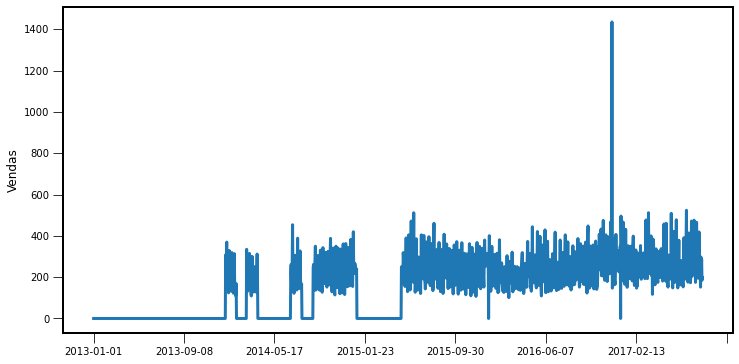

In [8]:
# plot da série temporal completa
plt.figure(figsize = (12, 6))
df41_hc['sales'].plot()
plt.xlabel('')
plt.ylabel('Vendas')
plt.show()

Existem diversos períodos com nenhuma venda de produto, que provalmente são períodos em que a loja esteve fechada ou existem problemas nos dados. As análises serão realizadas somente na parte mais recente da série, onde não existem peŕiodos longos sem venda. 

Um primeiro recorte é realizados abaixo na data de 2015-01-23.

In [9]:
# seleciona somente a parte da série a partir do dia 2015-01-23
df41_hc = df41_hc.loc["2015-01-23":]

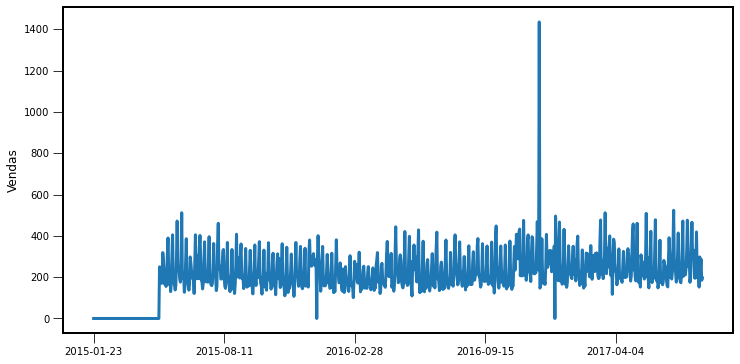

In [10]:
# novo plot da série temporal, agora a partir do dia 2015-01-23
plt.figure(figsize = (12, 6))
df41_hc['sales'].plot()
plt.xlabel('')
plt.ylabel('Vendas')
plt.show()

Uma parte da série sem vendas foi eliminada, mas ainda tem-se um período de vendas nulas. A seguir, o fim desse período é identificado e somente o período sem janelas nulas é selecionado.

In [11]:
# identifica a primeira data com vendas
vendas = 0 
idx = 0

while vendas == 0:
    vendas = df41_hc['sales'].iloc[idx]
    date = df41_hc.index[idx]
    idx += 1

In [12]:
print('A partir do dia {} a série não apresenta mais janelas sem vendas.'.format(date))

A partir do dia 2015-05-04 a série não apresenta mais janelas sem vendas.


In [13]:
# seleciona somente a parte da série sem janelas sem vendas
df41_hc = df41_hc.loc[date:]

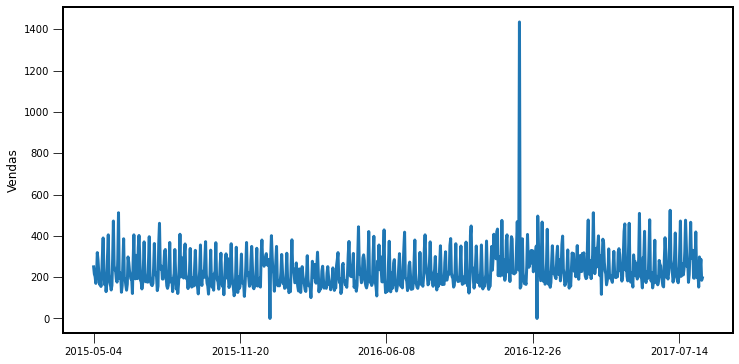

In [14]:
# novo plot a partir do dia 2015-05-04
plt.figure(figsize = (12, 6))
df41_hc['sales'].plot()
plt.xlabel('')
plt.ylabel('Vendas')
plt.show()

Existem ainda dois dias com vendas nulas. Será visto a seguir quais são esses dias.

In [15]:
# identifica os dias sem vendas
zero = []
for i in range(len(df41_hc['sales'])):
    if df41_hc['sales'].iloc[i] == 0:
        zero.append(df41_hc['sales'].index[i])
        
zero

['2016-01-01', '2017-01-01']

Os dias sem venda são os dias 1 de janeiro dos anos de 2016 e 2017, nos quais a loja muito provavelmente esteve fechada.

Por fim, nota-se ainda que existe um dia com vendas muito acima dos valores usuais. Esse número pode ser um erro no cadastro ou, talvez, algum evento especial na loja. Aqui, ele será tratado como outlier e o seu valor será substituído pela média das vendas do dia anterior e do dia seguinte.

In [16]:
# identifica o dia com o alto valor nas vendas
supersales = []
for i in range(len(df41_hc['sales'])):
    if df41_hc['sales'].iloc[i] > 1000:
        supersales.append(df41_hc['sales'].index[i])
        
supersales

['2016-12-07']

In [17]:
print('Somente no dia {} foram vendidos mais de 1000 itens.'.format(supersales[0]))

Somente no dia 2016-12-07 foram vendidos mais de 1000 itens.


In [18]:
# substitui as vendas do dia fora do padrão usual pela média dos valores do dia anterior e seguinte
df41_hc['sales'].loc['2016-12-07'] = (df41_hc['sales'].loc['2016-12-06'] + df41_hc['sales'].loc['2016-12-08'])/2 

In [19]:
# novo valor para o dia 2016-12-07
df41_hc['sales'].loc['2016-12-07']

191.0

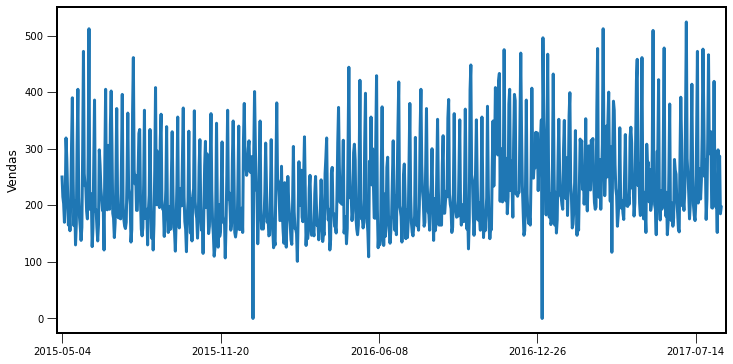

In [20]:
# plot da série temporal após o pré-tratamento
plt.figure(figsize = (12, 6))
ax = df41_hc['sales'].plot()
ax.set_xlim(np.array([35, -35])+ax.get_xlim())
plt.xlabel('')
plt.ylabel('Vendas')
plt.show()

In [21]:
print('A série que será analisada vai de {} a {} e contém {} registros.'.format(df41_hc.index[0], df41_hc.index[-1], df41_hc.shape[0]))

A série que será analisada vai de 2015-05-04 a 2017-08-15 e contém 833 registros.


## As funções de autocorrelação e autocorrelação parcial

In [22]:
# importa o pacote statsmodels para calcular e visualizar as funções de autocorrelação
import statsmodels.api as sm
import statsmodels

A função de autocorrelação (ou, do inglês, acf) calcula a correlação dos dados com os próprios dados da série em períodos anteriores. 

Na imagem abaixo, o pacote statsmodels é utilizado para vizualizar a acf da série. Nesse caso, foi escolhida a opção de mostrar as correlações para um período de até 40 dias. 

Na imagem, observa-se a correlação trivial com o período anterior ("lag") de zero dias, que é obviamente igual a 1. Ou seja, o coeficiente de correlação das vendas de um dia com esse mesmo dia é igual a 1, como esperado.   

Existem correlações positivas com "lags" de 1, 6, 7, 8, 13, 14, 15, 20, 21, 22 ... dias. E correlações negativas ocorrem nos "lags" de 2, 3, 4, 5, 9, 10, 11, 12, ... dias. Nota-se uma forte correlação com as vendas de 7 dias atrás, indicando uma forte dependência nas vendas com o dia da semana. Essa dependência com o dia da semana ainda é responsável pelo padrão periódico observado. 

Para selecionar somente os "lags" principais dentro desse padrão periódico é utilizada a função de autocorrelação parcial (que muitas vezes é escrita pela sigla em inglês pacf). Mais abaixo o pacote statsmodels é novamente utilizado para produzir o gráfico da pacf da série. Na figura fica bastante claro a atenuação dos valores da correlação conforme avança-se no padrão repetitivo.   

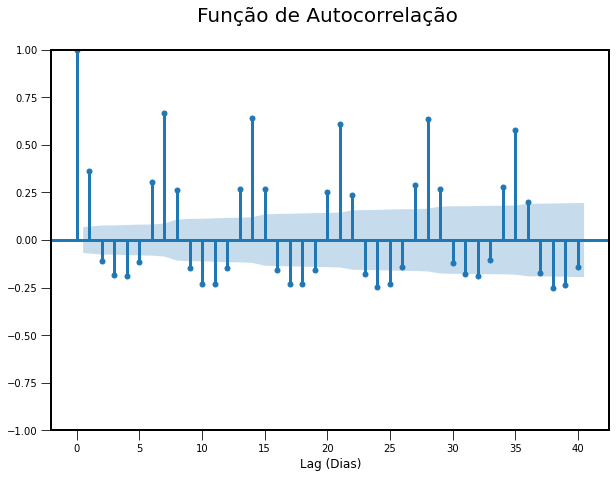

In [23]:
# plot da função de autocorrelção 
plt.rc("figure", figsize=(10,7))
sm.graphics.tsa.plot_acf(df41_hc['sales'], lags=40)
plt.xlabel('Lag (Dias)')
plt.title('Função de Autocorrelação \n', size=20)
plt.show()

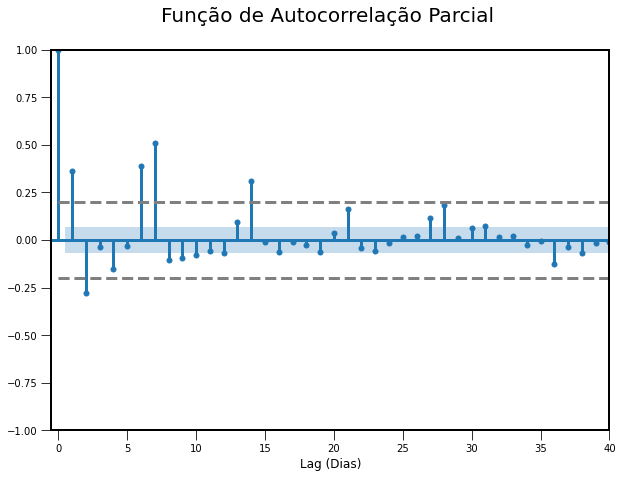

In [113]:
# plot da função de autocorrelação parcial
plt.rc("figure", figsize=(10,7))
sm.graphics.tsa.plot_pacf(df41_hc['sales'], lags=40, method = "ywm")
plt.hlines(0.2, 0, 40, color = 'gray', linestyle = '--')
plt.hlines(-0.2, 0, 40, color = 'gray', linestyle = '--')
plt.title('Função de Autocorrelação Parcial \n', size = 20)
plt.xlabel('Lag (Dias)')
plt.xlim(-0.5, 40)
plt.show()

Os "lags" principais, que serão utilizados no modelo de Machine Learning, são selecionados como aqueles com valor absoluto de autocorrelação maior do que 0.2. Na figura acima a linha cinza horizontal indica esse limiar.  

In [114]:
# calcula a função de autocorrelação parcial
pacf = statsmodels.tsa.stattools.pacf(df41_hc['sales'], nlags=40, method = "ywm")
pacf

array([ 1.        ,  0.36339423, -0.27764486, -0.03788827, -0.15262446,
       -0.03393817,  0.38788363,  0.50829614, -0.10571845, -0.09499421,
       -0.07741592, -0.0571428 , -0.06637366,  0.09371952,  0.31182502,
       -0.00916101, -0.06395787, -0.00800268, -0.02519255, -0.06071564,
        0.03946073,  0.16530507, -0.04312689, -0.05646253, -0.01567438,
        0.01680752,  0.01885416,  0.11422647,  0.18523266,  0.01214841,
        0.06261502,  0.07632448,  0.01555562,  0.01906066, -0.02838614,
       -0.00438055, -0.12361567, -0.0382009 , -0.07065498, -0.01453461,
       -0.0085616 ])

## Construindo o dataframe para a aplicação das técnicas de Machine Learning

### Incluindo os "lags" principais como "features"

O ponto central da técnica de Machine Learning para a análise de Séries Temporais que será utilizada aqui consiste em transformar os atrasos ("lags") principais em "features" para o aprendizado. 

Portanto, inicialmente esses atrasos principais serão identificados.

In [115]:
# identifica as lags nas quais o coeficiente de correlação é maior do que o limiar 0.2
lags = []

for i in range(1, len(pacf)):
    if abs(pacf[i]) > 0.2:
        lags.append(i)

# lista com as lags principais        
lags

[1, 2, 6, 7, 14]

Têm-se dessa forma 5 valores de atraso que serão utilizados nos modelos. Ou seja, as vendas em um determinado dia terão como variáveis os valores de venda a 1, 2, 6, 7, e 14 dias atrás.

In [116]:
# cria um dataframe com as quantidades vendidas nos dias anteriores correspondentes aos "lags" principais  
def lag_features_frame(data):
    '''
        Recebe o dataframe "data" com a série temporal original e retorna
        um novo dataframe com as vendas nos dias anteriores correspondentes
        aos "lags" principais
    
    '''
    
    lag_features = pd.DataFrame()

    for l in lags:
        lag_features['lag' + str(l)] = data.shift(l)['sales']

    return lag_features.iloc[max(lags):]

In [117]:
# chama a função lag_features_frame no dataframe da série temporal de interesse e cria a primeira parte
# do dataframe "df_forecast" que será utilizado no aprendizado de máquina
df_forecast = lag_features_frame(df41_hc)
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14
date,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0
2015-05-19,245.0,390.0,190.0,165.0,215.0
2015-05-20,164.0,245.0,155.0,190.0,203.0
2015-05-21,208.0,164.0,206.0,155.0,170.0
2015-05-22,130.0,208.0,308.0,206.0,206.0


### Incluindo o número de itens em promoção 

A coluna "onpromotion" indica o número de itens em promoção de uma família de produtos. Essa variável é incluída no dataframe "df_forecast"

In [118]:
# cria a coluna "onpromotion" no dataframe "df_forecast"
df_forecast['onpromotion'] = df41_hc['onpromotion'].copy()
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14,onpromotion
date,,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0,1
2015-05-19,245.0,390.0,190.0,165.0,215.0,1
2015-05-20,164.0,245.0,155.0,190.0,203.0,0
2015-05-21,208.0,164.0,206.0,155.0,170.0,2
2015-05-22,130.0,208.0,308.0,206.0,206.0,1


### Incluindo o preço do petróleo

É disponibilizado na fonte dos dados os dados dos valores do petróleo no período correspondente.

In [119]:
# carrega os dados do preço do petróleo
oil = pd.read_csv('oil.csv', index_col = ['date'])
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [120]:
# cria uma nova coluna no dataframe "df_forecast" com o valor do petróleo. 
df_forecast['oil'] = oil['dcoilwtico']
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14,onpromotion,oil
date,,,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0,1,59.44
2015-05-19,245.0,390.0,190.0,165.0,215.0,1,57.30
2015-05-20,164.0,245.0,155.0,190.0,203.0,0,58.96
2015-05-21,208.0,164.0,206.0,155.0,170.0,2,60.18
2015-05-22,130.0,208.0,308.0,206.0,206.0,1,58.88


### Incluindo os feriados

In [121]:
# carrega o dataframe com os feriados do Equador, que é disponibilizado no Kaggle
holiday = pd.read_csv('holidays_events.csv', index_col = ['date'])
holiday.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Na lista de feriados existem diversos feriados locais e, uma vez que a análise está sendo feita para somente uma das lojas da rede, somente os feriados nacionais foram considerados. Há também feriados que foram transferidos e celebrados em outras datas. Esses feriados não foram considerados nas análises.

In [122]:
# mantém no dataframe "holiday" somente os feriados nacionais que não tiveram o dia da celebração transferido
holiday = holiday[(holiday['locale'] == 'National') & (holiday['transferred'] == False)]

In [123]:
def is_holiday(date):
    '''
    Recebe uma data e retorna 1 se a data é um feriado e 0 caso contrário
    
    :param date: data no formato de string
    '''
    days = holiday.index
    if date in days:
        return 1
    else:
        return 0    

In [124]:
# aplica a função "is_holiday" nas datas do dataframe "df_forecast"
is_hol = pd.Series(df_forecast.index).apply(is_holiday)
is_hol.index = df_forecast.index
is_hol

date
2015-05-18    0
2015-05-19    0
2015-05-20    0
2015-05-21    0
2015-05-22    0
             ..
2017-08-11    1
2017-08-12    0
2017-08-13    0
2017-08-14    0
2017-08-15    0
Name: date, Length: 819, dtype: int64

In [125]:
# inclui no dataframe "df_forecast" a coluna 'holiday', que indica se o dia é um feriado ou não
df_forecast['holiday'] = is_hol
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14,onpromotion,oil,holiday
date,,,,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0,1,59.44,0
2015-05-19,245.0,390.0,190.0,165.0,215.0,1,57.30,0
2015-05-20,164.0,245.0,155.0,190.0,203.0,0,58.96,0
2015-05-21,208.0,164.0,206.0,155.0,170.0,2,60.18,0
2015-05-22,130.0,208.0,308.0,206.0,206.0,1,58.88,0


### Incluindo as datas de pagamento do setor público

Os pagamentos no setor público do Equador ocorrem a cada duas semanas. Um pagamento é realizado no dia 15 e o outro é realizado no último dia do mês. Acredita-se que esse fator pode afetar as vendas e ele é, portanto, incluído nas análises.

Ao invés de criar uma variável que simplesmente indica se a data é dia de pagamento ou não, aqui os dias de pagamento serão considerados através de uma variável que informa os dias corridos desde o pagamento. Espera-se que quanto mais próximo do pagamento maiores as vendas e conforme a pagamento fica mais distante o seu efeito nas vendas decai gradualmente.

In [126]:
def days_from_payment(dates):
    '''
    Recebe datas dentro de um período e retorna uma lista com a distância
    em dias de cada data aos dias de pagamento
    '''
    days = []
    for i in range(len(dates) - 1):
        # seleciona somente o dia a partir da string com a data
        date = float(dates[i][-2:]) 
        if date < 15:
            days.append(date)
        # verifica se a data é o último dia do mês
        elif dates[i+1][-2:] == '01': 
            days.append(0)
        else:
            days.append(date - 15) 

    days.append(0)
    
    return days    

In [127]:
# cria uma nova coluna para o dataframe "df_forecast" contendo os dias desde o último pagamento
df_forecast['days_from_payment'] = days_from_payment(df_forecast.index)
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14,onpromotion,oil,holiday,days_from_payment
date,,,,,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0,1,59.44,0,3.0
2015-05-19,245.0,390.0,190.0,165.0,215.0,1,57.30,0,4.0
2015-05-20,164.0,245.0,155.0,190.0,203.0,0,58.96,0,5.0
2015-05-21,208.0,164.0,206.0,155.0,170.0,2,60.18,0,6.0
2015-05-22,130.0,208.0,308.0,206.0,206.0,1,58.88,0,7.0


Com essa nova "feature", todas as variáveis que serão consideradas foram finalmente incluídas no dataframe. Agora falta apenas incluir a coluna com as vendas.

In [128]:
# adiciona a coluna "sales" ao dataframe "df_forecast"
df_forecast['sales'] = df41_hc['sales'].copy()
df_forecast.head()

,lag1,lag2,lag6,lag7,lag14,onpromotion,oil,holiday,days_from_payment,sales
date,,,,,,,,,,
2015-05-18,390.0,308.0,165.0,227.0,250.0,1,59.44,0,3.0,245.0
2015-05-19,245.0,390.0,190.0,165.0,215.0,1,57.30,0,4.0,164.0
2015-05-20,164.0,245.0,155.0,190.0,203.0,0,58.96,0,5.0,208.0
2015-05-21,208.0,164.0,206.0,155.0,170.0,2,60.18,0,6.0,130.0
2015-05-22,130.0,208.0,308.0,206.0,206.0,1,58.88,0,7.0,167.0


O dataframe está agora pronto para a aplicação de algorítmos de Machine Learning.

## Aplicando o algorítmo XGBoost de regressão na previsão das vendas

### Descrição geral da aplicação do método

In [129]:
# importando as bibliotecas de Machine Learning
import sklearn
from xgboost.sklearn import XGBRegressor

O algorítmo XGBoost para regressão será treinado nos dados da série e utilizado para prever as vendas em uma janela de 15 dias. Os 15 dias finais da série não serão considerados no treinamento e serão utilizados como testes da eficiência do modelo. 

In [130]:
def run_model(window, df_feat):
    '''
    Recebe o tamanho da janela de previsões e o dataframe pré-processado e realiza o treinamento
    no período anterior a janela de previsão. É retornado então o modelo treinado.
    
    :param window: int - tamanho da janela de previsões
    :param df_feat: dataframe
    '''
    X_train = df_feat.iloc[:-window, :-1]
    y_train = df_feat.iloc[:-window, -1]
    
    xgb = XGBRegressor()
    
    xgb.fit(X_train, y_train)
    
    return xgb

Existem basicamente duas maneiras de realizar as predições dentro desse método. A maneira mais simples é utilizar o modelo já treinado para fazer previsões em todas as datas selecionadas para testes. A outra maneira é realizar uma previsão na primeira data do conjunto de testes e então incluir o resultado da predição nas tabelas e retreinar o modelo para a próxima predição. Esse processo é repetido até a data final do conjunto de testes. Aqui será utilizado o primeiro procedimento.

In [131]:
def prediction(window, df_series, df_feat, model):
    '''
    Recebe a janela de previsão, o dataframe da série temporal, o dataframe com as features e o modelo treinado
    e retorna as predições dentro da janela determinada
    
    :param window: int - tamanho em dias da janela de previsão
    :param df_series: dataframe - dados da séries temporal. 
                                  É utilizado para recalcular os valores das vendas nos lags correspondentes
                                  após cada predição.
    :param df_feat: dataframe - contém as features. É atualizado após cada previsão. 
    :param model: modelo treinado.  
    '''
    df_time = df_series.copy()
    y_predictions = []

    for i in range(window): 

        x_test = df_feat.iloc[[-window + i],:-1]
        
        y_predictions.append(model.predict(x_test)[0])
        # substitui o valor das vendas pelo valor predito 
        df_time['sales'][-window + i] = y_predictions[-1]
        # recalcula as features correspondentes aos "lags"    
        df_feat.iloc[:, :len(lags)] = lag_features_frame(df_time)    

    return y_predictions

### Rodando o modelo somente com as features relacionadas às autocorrelações na série

Aqui, portanto, somente as colunas correspondentes aos valores de venda nos devidos tempos anteriores.

In [132]:
# roda o modelo deixando uma janela de 15 dias para testes
model = run_model(15, df_forecast.drop(['days_from_payment', 'oil', 'onpromotion', 'holiday'], axis = 1))

In [133]:
# faz predições na janela de 15 dias de testes
y_pred = prediction(15, df41_hc, df_forecast.drop(['days_from_payment', 'oil', 'onpromotion', 'holiday'], axis = 1), model)

/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py

In [134]:
# seleciona os valores realizados na janela de teste para serem comparados com os preditos
y_true = df41_hc.iloc[-15:, :]['sales']

In [135]:
# importa o pacote mean_absolute_error, que computa a métrica de avaliação de mesmo nome
from sklearn.metrics import mean_absolute_error

In [136]:
MAE1 = mean_absolute_error(y_true, y_pred)

print('MAE1 = {}'.format(MAE1))

MAE1 = 48.22807006835937


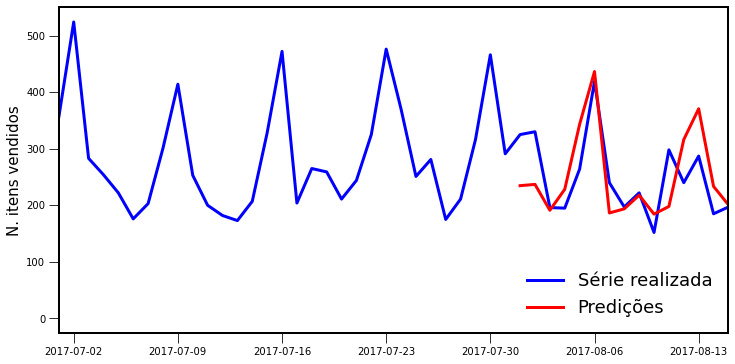

In [137]:
# visualizando as predições

#cria um dataframe com as precições, para serem exibidas na mesma figura da série realizada
df_pred = pd.DataFrame(y_pred, columns = ['sales'], index = y_true.index)

plt.figure(figsize = (12, 6))
plt.plot(df41_hc['sales'], label = 'Série realizada', color = 'b')
plt.plot(df_pred, label = 'Predições', color = 'r', linestyle = '-')
plt.xlim('2017-07-01','2017-08-15')
plt.xticks(pd.date_range('2017-07-01', periods = 7,  freq='W').strftime("%Y-%m-%d"))
plt.legend(loc = 'lower right', prop={'size': 18}, frameon = False)
plt.ylabel('N. itens vendidos', fontsize = 15)
plt.show()

### Rodando o modelo com todas as features 

In [48]:
# roda o modelo deixando uma janela de 15 dias para testes
model2 = run_model(15, df_forecast)

In [49]:
# faz predições na janela de 15 dias de testes
y_pred2 = prediction(15, df41_hc, df_forecast, model2)

/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py

In [50]:
MAE2 = mean_absolute_error(y_true, y_pred2)

print('MAE2 = {}'.format(MAE2))

MAE2 = 46.45408325195312


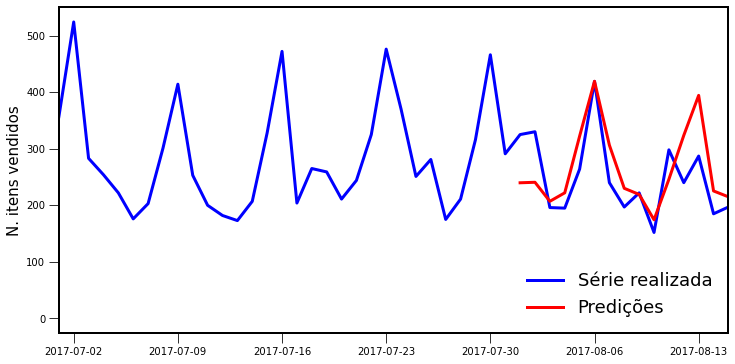

In [51]:
# visualizando as predições

#cria um dataframe com as precições, para serem exibidas na mesma figra da série realizada
df_pred2 = pd.DataFrame(y_pred2, columns = ['sales'], index = y_true.index)

plt.figure(figsize = (12, 6))
plt.plot(df41_hc['sales'], label = 'Série realizada', color = 'b')
plt.plot(df_pred2, label = 'Predições', color = 'r', linestyle = '-')
plt.xlim('2017-07-01','2017-08-15')
plt.xticks(pd.date_range('2017-07-01', periods = 7,  freq='W').strftime("%Y-%m-%d"))
plt.legend(loc = 'lower right', prop={'size': 18}, frameon = False)
plt.ylabel('N. itens vendidos', fontsize = 15)
plt.show()

### Rodando o modelo sem a informação sobre os pagamentos

In [52]:
# roda o modelo deixando uma janela de 15 dias para testes
model3 = run_model(15, df_forecast.drop(['days_from_payment'], axis = 1))

In [53]:
# faz predições na janela de 15 dias de testes
y_pred3 = prediction(15, df41_hc, df_forecast.drop(['days_from_payment'], axis = 1), model3)

/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['sales'][-window + i] = y_predictions[-1]
/tmp/ipykernel_15241/3768044395.py

In [54]:
MAE3 = mean_absolute_error(y_true, y_pred3)

print('MAE3 = {}'.format(MAE3))

MAE3 = 37.45216776529948


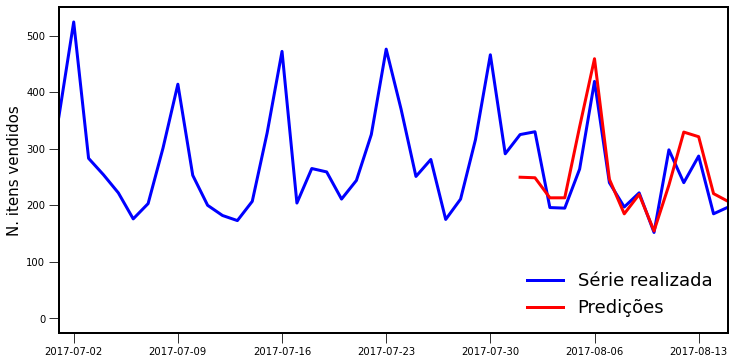

In [55]:
# visualizando as predições

#cria um dataframe com as precições, para serem exibidas na mesma figra da série realizada
df_pred3 = pd.DataFrame(y_pred3, columns = ['sales'], index = y_true.index)

plt.figure(figsize = (12, 6))
plt.plot(df41_hc['sales'], label = 'Série realizada', color = 'b')
plt.plot(df_pred3, label = 'Predições', color = 'r', linestyle = '-')
plt.xlim('2017-07-01','2017-08-15')
#plt.xticks(['2017-07-15'])
plt.xticks(pd.date_range('2017-07-01', periods = 7,  freq='W').strftime("%Y-%m-%d"))
plt.legend(loc = 'lower right', prop={'size': 18}, frameon = False)
plt.ylabel('N. itens vendidos', fontsize = 15)
plt.show()

Esse é o modelo de melhor performance dentre os modelos testados.



## Variáveis de importância

Para esse último modelo, será calculada a importância relativa de cada variável.

In [60]:
# calcula a importância relativa das variáveis
feat_importances = model3.feature_importances_

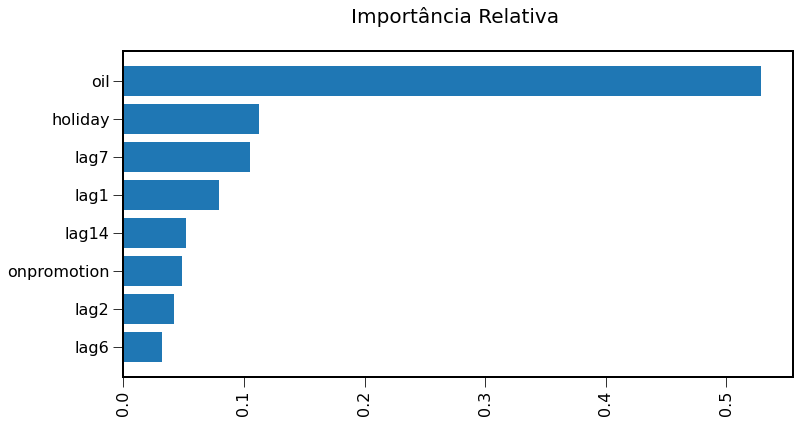

In [67]:
# ordena as variáveis em ordem ascendente de importância
sorted_feat_imp = np.sort(feat_importances)

# guarda a nova ordem dos índices após o reordenamento
arg = feat_importances.argsort()

# retorna o nome das variáveis
feature_names = df_forecast.drop(columns = ['days_from_payment', 'sales']).columns

# reordena os nomes de acordo com o ordenamento de importância
sorted_feat_names = feature_names[arg]

# barplot da importância relativa
fig = plt.figure(figsize = (12, 6))
plt.barh(sorted_feat_names, sorted_feat_imp)
plt.xticks(fontsize = 16, rotation = 90)
plt.yticks(fontsize = 16)
plt.title('Importância Relativa \n', fontsize = 20)
plt.show()

## Referências

- Fonte dos dados: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data
- Sobre a aplicação de Machine Learning em previsões de séries temporais: https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff